 # Investigating the Vanishing Gradient Problem


VGG-Deep

In [ ]:

import numpy
import matplotlib.pyplot as plot
import torch
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms
import torch
from torchsummary import summary


In [2]:
class VGGDeep(torch.torch.nn.Module):
    def __init__(self, numClasses=3):
        super(VGGDeep, self).__init__()

        def convLayer(in_channels, out_channels): 
            layers = [torch.torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                      torch.torch.nn.ReLU(inplace=False)]
            return layers

        self.features = torch.torch.nn.Sequential(
            *convLayer(3, 64),
            *convLayer(64, 64),
            torch.torch.nn.MaxPool2d(kernel_size=2, stride=2),

            *convLayer(64, 128),
            *convLayer(128, 128),
            torch.torch.nn.MaxPool2d(kernel_size=2, stride=2),

            *convLayer(128, 256),
            *convLayer(256, 256),
            *convLayer(256, 256),
            torch.torch.nn.MaxPool2d(kernel_size=2, stride=2),

            *convLayer(256, 512),
            *convLayer(512, 512),
            *convLayer(512, 512),
            torch.torch.nn.MaxPool2d(kernel_size=2, stride=2),

            *convLayer(512, 512),
            *convLayer(512, 512),
            *convLayer(512, 512),
            torch.torch.nn.MaxPool2d(kernel_size=2, stride=2),

            *convLayer(512, 1024),
            *convLayer(1024, 1024),
            *convLayer(1024, 2048),
            *convLayer(2048, 2048)
        )

        self.classifier = torch.torch.nn.Sequential(
            torch.torch.nn.Linear(2048 * 7 * 7, 4096),
            torch.torch.nn.ReLU(inplace=False),
            torch.torch.nn.Linear(4096, 4096),
            torch.torch.nn.ReLU(inplace=False),
            torch.torch.nn.Linear(4096, numClasses))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
transform = transforms.Compose([  
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

cnnDataset = datasets.ImageFolder(root = 'cnn_dataset', transform = transform)

# Calculate class weights
countOfClasses = {i: 0 for i in cnnDataset.classes}
sampleWeights = [1.0 / numpy.array(list(countOfClasses.values()))[label] for _, label in cnnDataset]

sampler = WeightedRandomSampler(sampleWeights, len(cnnDataset)) # Creating sampler

trainLoader = DataLoader(cnnDataset, batch_size=32, sampler=sampler) # DataLoader with sampler

# Split dataset into 70% train, 15% validation, 15% test
trainValSize = int(0.85 * len(cnnDataset))
testSize = len(cnnDataset) - trainValSize
trainValDataset, testDataset = random_split(cnnDataset, [trainValSize, testSize])

trainSize = int(0.7 * len(trainValDataset))
valSize = len(trainValDataset) - trainSize
trainDataset, valDataset = random_split(trainValDataset, [trainSize, valSize])

# Create DataLoader
trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=32, shuffle=False)

In [4]:
def gradientHook(gradOutput, module, gradInput, gradientNorms, index):
    if isinstance(gradOutput, tuple):
        gradOutput = gradOutput[0]
    gradNorm = gradOutput.norm(p=2).item()
    gradientNorms[index].append(gradNorm)


In [ ]:

def trainVGGModel(model, trainLoader, valLoader, optimizer, criterion, device, iterations, gradientNorms):
    model.train()
    hooks = []
    for i, layer in enumerate(model.features):
        if isinstance(layer, torch.nn.Conv2d):
            hook = layer.register_full_backward_hook(lambda module, gradInput, gradOutput, i=i: gradientHook(gradOutput, module, gradInput, gradientNorms, i))
            hooks.append(hook)
            gradientNorms[i] = []

    trainAccuracies = []
    trainLosses = []
    valAccuracies = []
    valLosses = []

    for iteration in range(iterations):
        runningLoss, correctTrain, totalTrain = 0.0, 0, 0
        
        for inputs, labels in trainLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            totalTrain = totalTrain + labels.size(0)
            runningLoss = runningLoss + loss.item()
            correctTrain = correctTrain + (predicted == labels).sum().item()

        trainAccuracy = (correctTrain / totalTrain) * 100
        trainLoss = runningLoss / len(trainLoader)

        trainAccuracies.append(trainAccuracy)
        trainLosses.append(trainLoss)

        model.eval()
        correctVal, totalVal, valLoss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in valLoader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                totalVal = totalVal + labels.size(0)
                correctVal = correctVal + (predicted == labels).sum().item()
                valLoss = valLoss + loss.item()

        valAccuracy = (correctVal / totalVal) * 100
        valLoss = valLoss / len(valLoader)

        valAccuracies.append(valAccuracy)
        valLosses.append(valLoss)

        print(f"Iteration {iteration + 1}: Train Loss: {trainLoss:.4f}, Train Accuracy: {trainAccuracy:.2f}%, Validation Loss: {valLoss:.4f}, Validation Accuracy: {valAccuracy:.2f}%")

        model.train()

    for hook in hooks:
        hook.remove()

    return trainAccuracies, trainLosses, valAccuracies, valLosses


def evaluateVGGModel(model, testLoader, device, criterion):
    model.eval()
    correctTest = 0
    totalTest = 0
    testLoss = 0.0

    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            totalTest = totalTest + labels.size(0)
            correctTest = correctTest + (predicted == labels).sum().item()
            testLoss = testLoss + loss.item()

    testAccuracy = (correctTest / totalTest) * 100
    testLoss = testLoss / len(testLoader)

    print(f'Test Accuracy: {testAccuracy:.4f}, Test Loss: {testLoss:.4f}')
    return testAccuracy, testLoss


In [6]:
def plotGradientNorms(gradientNorms, trackLayers):
    def plotGradients(selectedLayers, title):
        plot.figure(figsize=(10, 6))
        validNorms = []

        for layerIndex in selectedLayers: # only selected layers
            if layerIndex not in gradientNorms:
                continue
            
            norms = numpy.array(gradientNorms[layerIndex])
            if norms.ndim > 1:
                norms = numpy.mean(norms, axis=0)

            if numpy.isscalar(norms) or numpy.isnan(norms).any(): # Skipping nan values
                continue

            norms = numpy.nan_to_num(norms)  # Replacing NaNs with zero
            validNorms.append(norms)

            iterations = numpy.arange(len(norms))
            plot.plot(iterations, norms, label=f"Layer {layerIndex + 1}")

        plot.xlabel('iterations')
        plot.ylabel('Average Gradient Norm')
        plot.title(title)
        plot.yscale('log')

        if validNorms:
            plot.ylim(1e-9, 2 * numpy.max(validNorms))

        plot.legend(loc='upper right')
        plot.grid(True, linestyle="--", linewidth=0.5)
        plot.show()

    plotGradients(gradientNorms.keys(), "Gradient Norms for Each Convolutional Layer")
    plotGradients(trackLayers, "Gradient Norm Comparison for Selected Layers")

Iteration 1: Train Loss: 0.7324, Train Accuracy: 75.39%, Validation Loss: 0.7328, Validation Accuracy: 63.38%
Iteration 2: Train Loss: 0.7324, Train Accuracy: 75.39%, Validation Loss: 0.7328, Validation Accuracy: 63.38%
Iteration 3: Train Loss: 0.7324, Train Accuracy: 75.39%, Validation Loss: 0.7328, Validation Accuracy: 63.38%
Iteration 4: Train Loss: 0.7324, Train Accuracy: 75.39%, Validation Loss: 0.7328, Validation Accuracy: 63.38%
Iteration 5: Train Loss: 0.7324, Train Accuracy: 75.39%, Validation Loss: 0.7328, Validation Accuracy: 63.38%
Iteration 6: Train Loss: 0.7323, Train Accuracy: 75.39%, Validation Loss: 0.7328, Validation Accuracy: 63.38%
Iteration 7: Train Loss: 0.7324, Train Accuracy: 75.39%, Validation Loss: 0.7328, Validation Accuracy: 63.38%
Iteration 8: Train Loss: 0.7323, Train Accuracy: 75.39%, Validation Loss: 0.7328, Validation Accuracy: 63.38%
Iteration 9: Train Loss: 0.7324, Train Accuracy: 75.39%, Validation Loss: 0.7328, Validation Accuracy: 63.38%
Iteration 

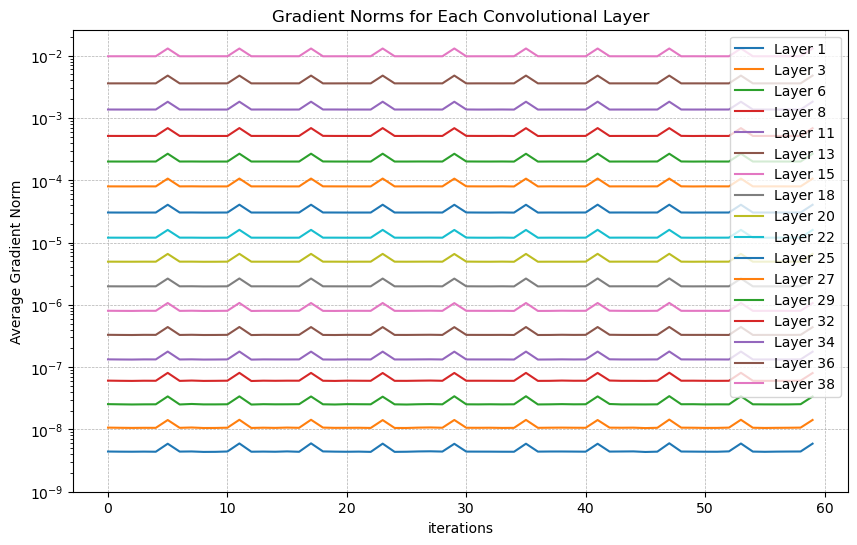

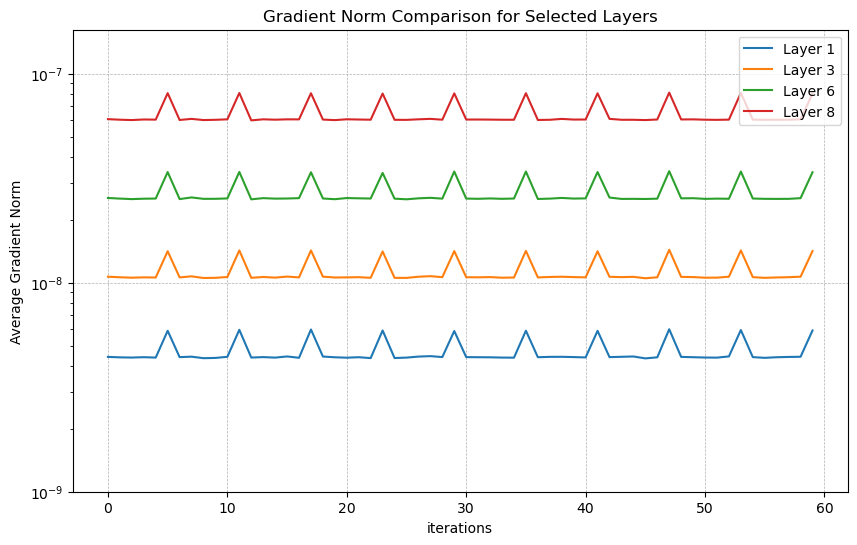

Test Accuracy: 82.2222, Test Loss: 0.7319


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelVGGDeep = VGGDeep(numClasses=3).to(device)
optimizer = torch.optim.SGD(modelVGGDeep.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
gradientNorms = {i: [] for i, layer in enumerate(modelVGGDeep.features) if isinstance(layer, torch.nn.Conv2d)}
convLayers = [i for i, layer in enumerate(modelVGGDeep.features) if isinstance(layer, torch.nn.Conv2d)]
trackLayers = convLayers[:4] 
iterations = 10

trainAccuraciesVGGDeep, trainLossesVGGDeep, valAccuraciesVGGDeep, valLossesVGGDeep = trainVGGModel(modelVGGDeep, trainLoader, valLoader, optimizer, criterion, device, iterations, gradientNorms)
plotGradientNorms(gradientNorms, trackLayers)
testAccuracyVGGDeep, testLossVGGDeep = evaluateVGGModel(modelVGGDeep, testLoader, device, criterion)


##  Comparison with VGG-16 and ResNet-18

- Compare the training curves (loss and accuracy vs. epoch) of VGG-Deep, VGG-16, and ResNet-18.

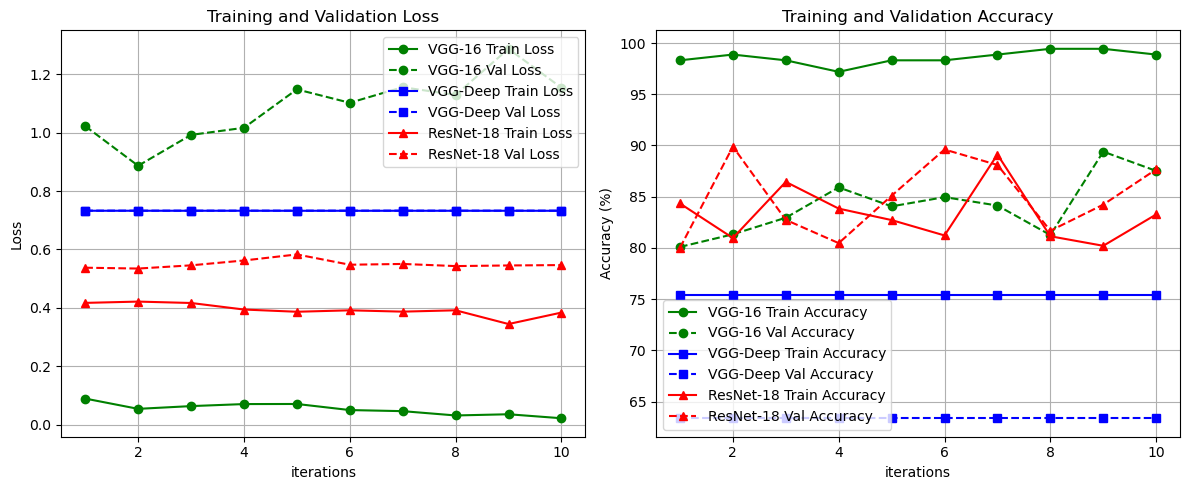

In [ ]:
# Picking the values from part 1

# 10 iterations

VGGAccuracy =  89.4
VGGTrainingLosses =  [0.08895892029007275, 0.05375695383797089, 0.06315898646910985, 0.07012745396544535, 0.07043919914091627, 0.04960936649392048, 0.04586330785726508, 0.03110610965328912, 0.03521840771039327, 0.02155230943268786]
VGGValidationLosses =  [1.0225013891855876, 0.886545287238227, 0.9923242727915446, 1.0166859361860487, 1.1482821570502388, 1.102276537153456, 1.155759334564209, 1.129167742199368, 1.2872660954793294, 1.1538496547275119]
VGGTrainingAccuracies =  [98.31460674157303, 98.87640449438202, 98.31460674157303, 97.19101123595506, 98.31460674157303, 98.31460674157303, 98.87640449438202, 99.43820224719101, 99.43820224719101, 98.87640449438202]
VGGValidationAccuracies =  [80.1, 81.33, 82.95, 85.91, 84.06, 84.96, 84.14, 81.26, 89.4, 87.52]
ResNetAccuracy =  89.89
ResNetTrainingLosses =  [0.41678253809611004, 0.4212157064014011, 0.4164380364947849, 0.39402380254533553, 0.38638540108998615, 0.3913257122039795, 0.3867870569229126, 0.39138139618767637, 0.344346092806922, 0.3835979633861118]
ResNetValidationLosses =  [0.5373266339302063, 0.5344269474347433, 0.545424222946167, 0.5620676080385844, 0.5827588240305582, 0.5475132862726847, 0.5502207477887472, 0.5428567330042521, 0.5450202425320944, 0.5462995370229086]
ResNetTrainingAccuracies =  [84.34, 80.97, 86.45, 83.84, 82.72, 81.22, 89.12, 81.14, 80.21, 83.27]
ResNetValidationAccuracies =  [80.01, 89.89, 82.74, 80.47, 85.1, 89.61, 88.1, 81.68, 84.23, 87.67]

def plotTrainingValidationCurves(VGG16TrainingLosses, VGG16ValidationLosses, VGG16TrainingAccuracies, VGG16ValidationAccuracies,
                                 VGGDeepTrainingLosses, VGGDeepValidationLosses, VGGDeepTrainingAccuracies, VGGDeepValidationAccuracies,
                                 ResNetTrainingLosses, ResNetValidationLosses, ResNetTrainingAccuracies, ResNetValidationAccuracies):
    iterations = range(1, len(VGG16TrainingLosses) + 1)

    plot.figure(figsize=(12, 5))

    # Plot Training and Validation Loss**
    plot.subplot(1, 2, 1)
    plot.plot(iterations, VGG16TrainingLosses, 'g-o', label="VGG-16 Train Loss")
    plot.plot(iterations, VGG16ValidationLosses, 'g--o', label="VGG-16 Val Loss")

    plot.plot(iterations, VGGDeepTrainingLosses, 'b-s', label="VGG-Deep Train Loss")
    plot.plot(iterations, VGGDeepValidationLosses, 'b--s', label="VGG-Deep Val Loss")

    plot.plot(iterations, ResNetTrainingLosses, 'r-^', label="ResNet-18 Train Loss")
    plot.plot(iterations, ResNetValidationLosses, 'r--^', label="ResNet-18 Val Loss")

    plot.xlabel("iterations")
    plot.ylabel("Loss")
    plot.title("Training and Validation Loss")
    plot.legend()
    plot.grid(True)

    # Plot Training and Validation Accuracy**
    plot.subplot(1, 2, 2)
    plot.plot(iterations, VGG16TrainingAccuracies, 'g-o', label="VGG-16 Train Accuracy")
    plot.plot(iterations, VGG16ValidationAccuracies, 'g--o', label="VGG-16 Val Accuracy")

    plot.plot(iterations, VGGDeepTrainingAccuracies, 'b-s', label="VGG-Deep Train Accuracy")
    plot.plot(iterations, VGGDeepValidationAccuracies, 'b--s', label="VGG-Deep Val Accuracy")

    plot.plot(iterations, ResNetTrainingAccuracies, 'r-^', label="ResNet-18 Train Accuracy")
    plot.plot(iterations, ResNetValidationAccuracies, 'r--^', label="ResNet-18 Val Accuracy")

    plot.xlabel("iterations")
    plot.ylabel("Accuracy (%)")
    plot.title("Training and Validation Accuracy")
    plot.legend()
    plot.grid(True)

    plot.tight_layout()
    plot.show()

plotTrainingValidationCurves(
    VGGTrainingLosses, VGGValidationLosses, VGGTrainingAccuracies, VGGValidationAccuracies,  # VGG-16
    trainLossesVGGDeep, valLossesVGGDeep, trainAccuraciesVGGDeep, valAccuraciesVGGDeep,  # VGG-Deep
    ResNetTrainingLosses, ResNetValidationLosses, ResNetTrainingAccuracies, ResNetValidationAccuracies  # ResNet-18
)


1.In very deep networks like VGG-Deep, gradients vanish, making training harder. <br>

2.ResNet has residual connections that allow gradients to bypass layers, helping them flow more easily.These layers improve gradient propagation, preventing the vanishing gradient issue in deep networks.Thus with residual connections, training deep networks becomes more stable and effective.


## Investigate and analyze more setups

In [ ]:
def trainModel(model, optimizer, criterion, trainLoader, valLoader, iterations=10, device='cpu'):
    model.to(device)
    trainLosses = []
    bestModel = None
    bestAccuracy = 0.0
    valLosses = []
    valAccuracies = []
    trainAccuracies = []

    for iteration in range(iterations):
        model.train()
        runningLoss = 0.0
        correctTrain = 0
        totalTrain = 0

        for inputs, labels in trainLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            runningLoss = runningLoss + loss.item()
            _, predicted = torch.max(outputs, 1)
            totalTrain = totalTrain + labels.size(0)
            correctTrain = correctTrain + (predicted == labels).sum().item()

        trainLoss = runningLoss / len(trainLoader)
        trainAccuracy = (correctTrain / totalTrain) * 100  
        
        trainLosses.append(trainLoss)
        trainAccuracies.append(trainAccuracy)

        model.eval()
        correctVal = 0
        totalVal = 0
        valLoss = 0.0
        with torch.no_grad():
            for inputs, labels in valLoader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                totalVal = totalVal + labels.size(0)
                valLoss = valLoss + loss.item()
                correctVal = correctVal + (predicted == labels).sum().item()

        valAccuracy = (correctVal / totalVal) * 100
        valLoss /= len(valLoader)

        valAccuracies.append(valAccuracy)
        valLosses.append(valLoss)

        if valAccuracy > bestAccuracy:
            bestAccuracy = valAccuracy
            bestModel = model

        print(f'Iteration {iteration+1}/{iterations}: Train Loss: {trainLoss:.4f}, Train Accuracy: {trainAccuracy:.4f}%, Val Loss: {valLoss:.4f}, Val Accuracy: {valAccuracy:.4f}%')

    return trainLosses, trainAccuracies, valLosses, valAccuracies, bestModel

def evaluateModel(model, testLoader, criterion, device='cuda'):
    model.eval()
    correctTest = 0
    totalTest = 0
    runningTestLoss = 0.0

    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            runningTestLoss = runningTestLoss + loss.item()
            _, predicted = torch.max(outputs, 1)
            totalTest = totalTest + labels.size(0)
            correctTest = correctTest + (predicted == labels).sum().item()

    testAccuracy = (correctTest / totalTest) * 100
    testLoss = runningTestLoss / len(testLoader)

    print(f'Test Loss: {testLoss:.4f} - Test Accuracy: {testAccuracy:.2f}%')
    return testLoss, testAccuracy

def plotResults(trainLosses, trainAccuracies, valLosses, valAccuracies, testLosses, testAccuracies, modelName="Model"):
    iterations = range(1, len(trainLosses) + 1)

    # Plot Losses
    plot.figure(figsize=(10, 5))
    plot.plot(iterations, trainLosses, label='Training Loss', color='b', linestyle='-', marker='o')
    plot.plot(iterations, valLosses, label='Validation Loss', color='g', linestyle='--', marker='s')
    plot.plot(iterations, testLosses, label='Test Loss', color='r', linestyle='-.', marker='^')
    plot.xlabel('iterations')
    plot.ylabel('Loss')
    plot.title(f'{modelName} - Loss over iterations')
    plot.legend()
    plot.grid(True)
    plot.show()

    # Plot Accuracies
    plot.figure(figsize=(10, 5))
    plot.plot(iterations, trainAccuracies, label='Training Accuracy', color='b', linestyle='-', marker='o')
    plot.plot(iterations, valAccuracies, label='Validation Accuracy', color='g', linestyle='--', marker='s')
    plot.plot(iterations, testAccuracies, label='Test Accuracy', color='r', linestyle='-.', marker='^')
    plot.xlabel('iterations')
    plot.ylabel('Accuracy (%)')
    plot.title(f'{modelName} - Accuracy over iterations')
    plot.legend()
    plot.grid(True)
    plot.show()




### Experiment 1 Max Pooling vs. Average Pooling

In [8]:
class VGGMaxPoolSmall(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(VGGMaxPoolSmall, self).__init__()
        
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2) # Max Pooling
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(256 * 28 * 28, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [9]:
class VGGAvgPoolSmall(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(VGGAvgPoolSmall, self).__init__()
        
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.AvgPool2d(kernel_size=2, stride=2) # Average Pooling
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(256 * 28 * 28, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [13]:
modelMaxpool = VGGMaxPoolSmall(num_classes=3).to(device)
modelAvgpool = VGGAvgPoolSmall(num_classes=3).to(device)

optimizerMaxpool = torch.optim.SGD(modelMaxpool.parameters(), lr=0.01, momentum=0.9)
optimizerAvgpool = torch.optim.SGD(modelAvgpool.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

Iteration 1/10: Train Loss: 0.7328, Train Accuracy: 68.6517%, Val Loss: 0.7321, Val Accuracy: 82.8571%
Iteration 2/10: Train Loss: 0.7256, Train Accuracy: 81.0000%, Val Loss: 0.7286, Val Accuracy: 72.4675%
Iteration 3/10: Train Loss: 0.7143, Train Accuracy: 82.0000%, Val Loss: 0.7213, Val Accuracy: 80.2597%
Iteration 4/10: Train Loss: 0.6824, Train Accuracy: 87.0000%, Val Loss: 0.6961, Val Accuracy: 81.5584%
Iteration 5/10: Train Loss: 0.6491, Train Accuracy: 84.0000%, Val Loss: 0.9739, Val Accuracy: 80.2597%
Iteration 6/10: Train Loss: 0.6894, Train Accuracy: 84.0000%, Val Loss: 0.6972, Val Accuracy: 83.6200%
Iteration 7/10: Train Loss: 0.6528, Train Accuracy: 82.0000%, Val Loss: 0.6796, Val Accuracy: 80.4500%
Iteration 8/10: Train Loss: 0.6233, Train Accuracy: 83.0000%, Val Loss: 0.6996, Val Accuracy: 86.5300%
Iteration 9/10: Train Loss: 0.5961, Train Accuracy: 86.0000%, Val Loss: 0.8502, Val Accuracy: 84.5500%
Iteration 10/10: Train Loss: 0.5631, Train Accuracy: 86.0000%, Val Loss: 

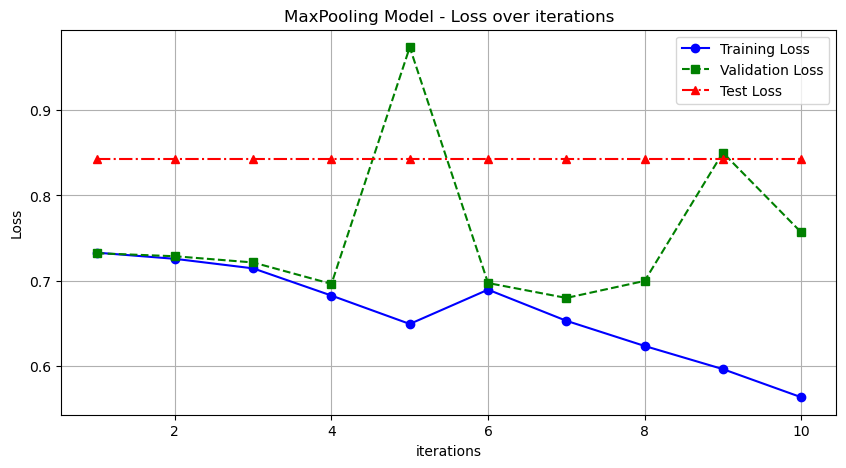

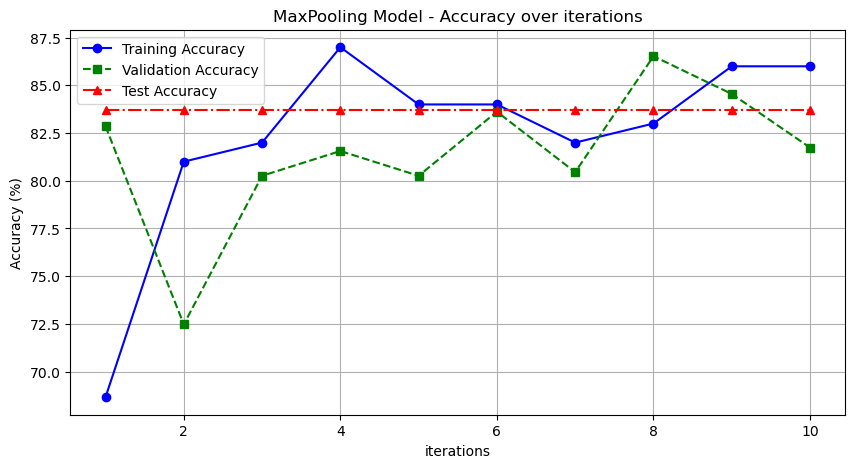

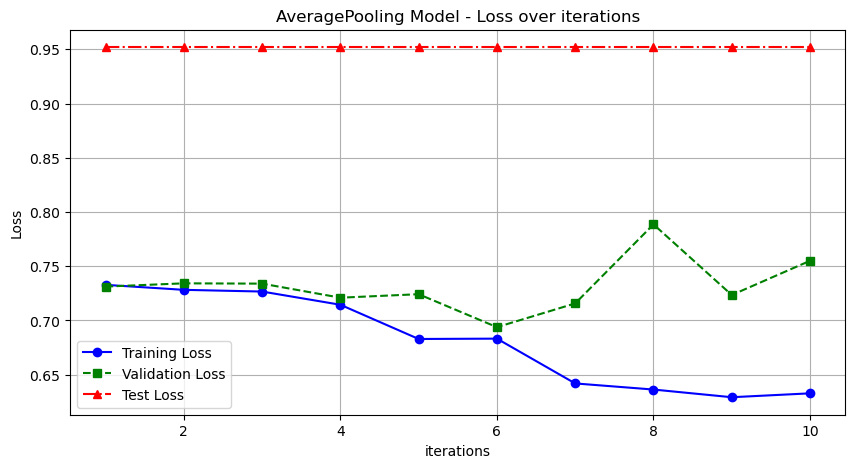

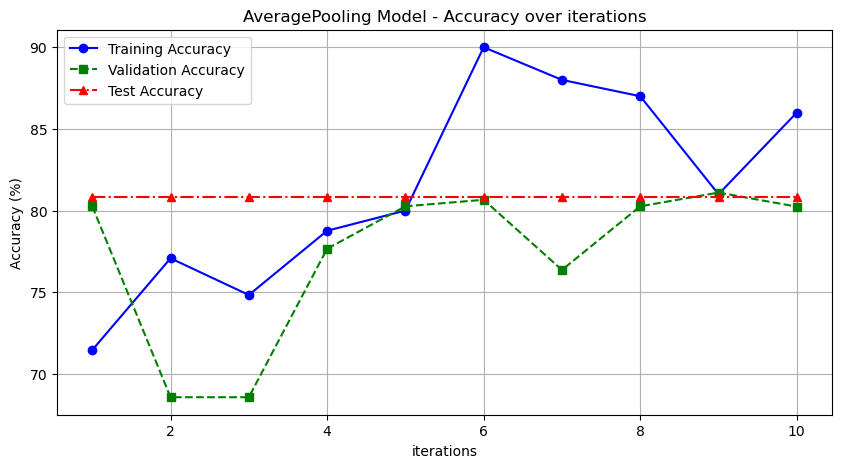

In [14]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainLossesMaxpool, trainAccuraciesMaxpool, valLossesMaxpool, valAccuraciesMaxpool, bestModelMaxpool = trainModel(modelMaxpool, optimizerMaxpool, criterion, trainLoader, valLoader, iterations=10, device=device)
trainLossesAvgpool, trainAccuraciesAvgpool, valLossesAvgpool, valAccuraciesAvgpool, bestModelAvgpool = trainModel(modelAvgpool, optimizerAvgpool, criterion, trainLoader, valLoader, iterations=10, device=device)

testLossMaxpool, testAccuraciesMaxpool = evaluateModel(modelMaxpool, testLoader, criterion, device=device)
testLossAvgPool, testAccuraciesAvgpool = evaluateModel(modelAvgpool, testLoader, criterion, device=device)

plotResults(trainLossesMaxpool, trainAccuraciesMaxpool, valLossesMaxpool, valAccuraciesMaxpool, [testLossMaxpool] * len(trainLossesMaxpool), [testAccuraciesMaxpool] * len(trainLossesMaxpool), "MaxPooling Model")
plotResults(trainLossesAvgpool, trainAccuraciesAvgpool, valLossesAvgpool, valAccuraciesAvgpool, [testLossAvgPool] * len(trainLossesMaxpool), [testAccuraciesAvgpool] * len(trainLossesAvgpool), "AveragePooling Model")


### Experiment 2 Activation functions

In [10]:
class VggLikeActivationTest(torch.nn.Module):
    def __init__(self, activationFn, numClasses=3):
        super(VggLikeActivationTest, self).__init__()
        self.activationFn = activationFn
        def convLayer(inChannels, outChannels):
            layers = [
                torch.nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1),
                activationFn(), # Activation Functions
                torch.nn.MaxPool2d(kernel_size=2, stride=2)
            ]
            return layers
        self.features = torch.nn.Sequential(
            *convLayer(3, 64),
            *convLayer(64, 128),
            *convLayer(128, 256),
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(256 * 28 * 28, 4096),
            activationFn(),
            torch.nn.Linear(4096, numClasses)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


Training with ReLU:
Iteration 1/10: Train Loss: 0.7208, Train Accuracy: 75.3933%, Val Loss: 0.8453, Val Accuracy: 73.7662%
Iteration 2/10: Train Loss: 0.7102, Train Accuracy: 83.0000%, Val Loss: 0.7485, Val Accuracy: 72.4675%
Iteration 3/10: Train Loss: 0.6570, Train Accuracy: 87.0000%, Val Loss: 0.7733, Val Accuracy: 77.6623%
Iteration 4/10: Train Loss: 0.6508, Train Accuracy: 86.0000%, Val Loss: 0.7604, Val Accuracy: 82.8571%
Iteration 5/10: Train Loss: 0.5952, Train Accuracy: 82.0000%, Val Loss: 0.7616, Val Accuracy: 77.6623%
Iteration 6/10: Train Loss: 0.5825, Train Accuracy: 80.0000%, Val Loss: 0.7317, Val Accuracy: 84.1558%
Iteration 7/10: Train Loss: 0.5477, Train Accuracy: 85.0000%, Val Loss: 0.7063, Val Accuracy: 80.2100%
Iteration 8/10: Train Loss: 0.5428, Train Accuracy: 86.0000%, Val Loss: 0.9000, Val Accuracy: 77.6623%
Iteration 9/10: Train Loss: 0.5936, Train Accuracy: 81.0000%, Val Loss: 0.7407, Val Accuracy: 85.4545%
Iteration 10/10: Train Loss: 0.5257, Train Accuracy:

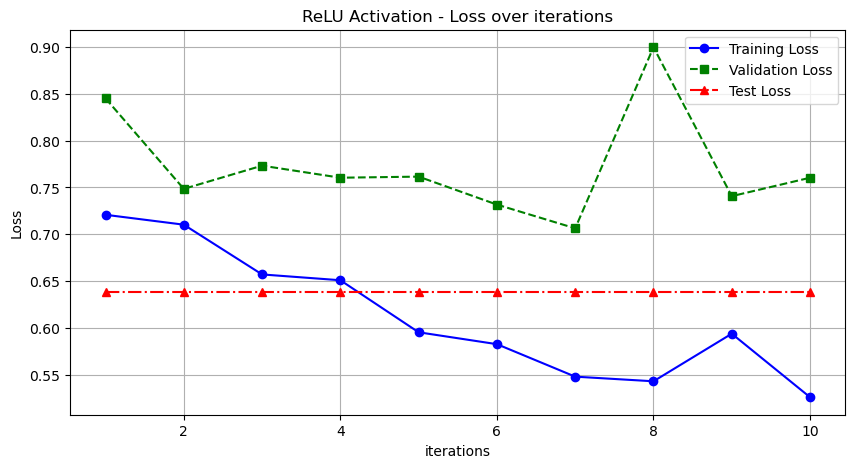

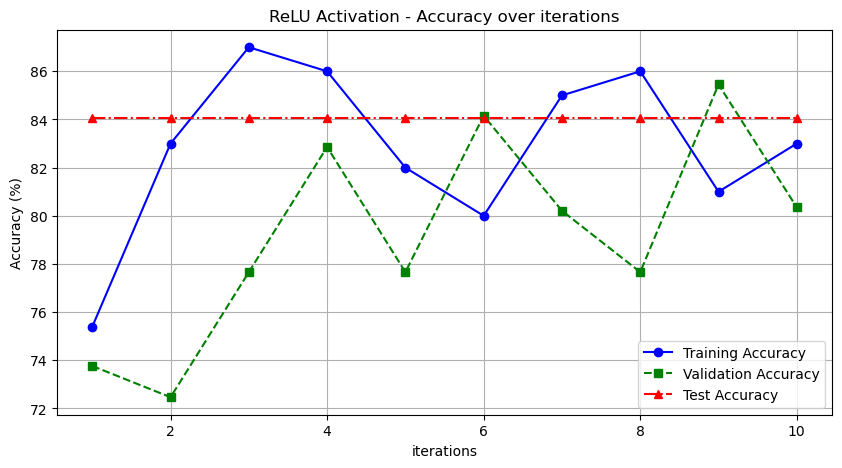


Training with LeakyReLU:
Iteration 1/10: Train Loss: 0.7269, Train Accuracy: 78.7640%, Val Loss: 0.7530, Val Accuracy: 73.7662%
Iteration 2/10: Train Loss: 0.7109, Train Accuracy: 81.0000%, Val Loss: 0.7759, Val Accuracy: 77.6623%
Iteration 3/10: Train Loss: 0.6660, Train Accuracy: 88.8764%, Val Loss: 0.7457, Val Accuracy: 85.2900%
Iteration 4/10: Train Loss: 0.6529, Train Accuracy: 85.0000%, Val Loss: 0.7185, Val Accuracy: 88.0519%
Iteration 5/10: Train Loss: 0.6598, Train Accuracy: 82.0000%, Val Loss: 0.7777, Val Accuracy: 78.9610%
Iteration 6/10: Train Loss: 0.6153, Train Accuracy: 89.0000%, Val Loss: 0.6985, Val Accuracy: 82.9300%
Iteration 7/10: Train Loss: 0.5785, Train Accuracy: 83.0000%, Val Loss: 0.7363, Val Accuracy: 80.2597%
Iteration 8/10: Train Loss: 0.5450, Train Accuracy: 86.0000%, Val Loss: 0.7039, Val Accuracy: 80.2500%
Iteration 9/10: Train Loss: 0.4857, Train Accuracy: 83.0000%, Val Loss: 0.6743, Val Accuracy: 86.7532%
Iteration 10/10: Train Loss: 0.4639, Train Accu

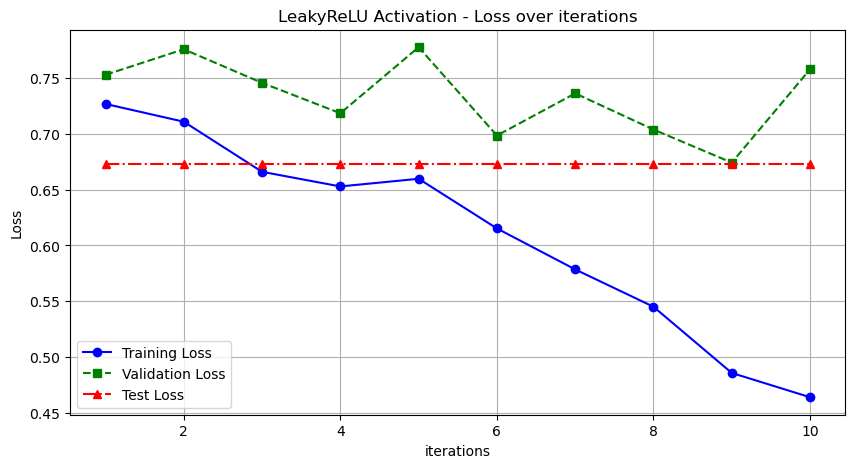

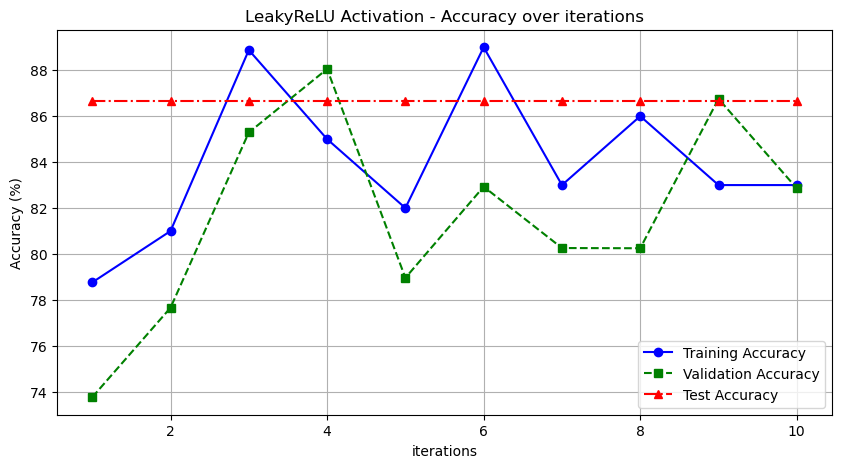


Training with ELU:
Iteration 1/10: Train Loss: 0.7665, Train Accuracy: 87.7528%, Val Loss: 0.7798, Val Accuracy: 77.6623%
Iteration 2/10: Train Loss: 0.7184, Train Accuracy: 82.6966%, Val Loss: 0.7469, Val Accuracy: 86.4400%
Iteration 3/10: Train Loss: 0.6410, Train Accuracy: 86.0000%, Val Loss: 0.8066, Val Accuracy: 81.5584%
Iteration 4/10: Train Loss: 0.5443, Train Accuracy: 86.0000%, Val Loss: 0.7174, Val Accuracy: 81.1900%
Iteration 5/10: Train Loss: 0.5516, Train Accuracy: 83.0000%, Val Loss: 0.6762, Val Accuracy: 83.1500%
Iteration 6/10: Train Loss: 0.4860, Train Accuracy: 86.0000%, Val Loss: 0.7231, Val Accuracy: 81.1300%
Iteration 7/10: Train Loss: 0.4481, Train Accuracy: 86.0000%, Val Loss: 0.7159, Val Accuracy: 85.7100%
Iteration 8/10: Train Loss: 0.4322, Train Accuracy: 80.0000%, Val Loss: 0.6854, Val Accuracy: 81.3000%
Iteration 9/10: Train Loss: 0.4206, Train Accuracy: 82.0000%, Val Loss: 0.8431, Val Accuracy: 82.2700%
Iteration 10/10: Train Loss: 0.4272, Train Accuracy: 

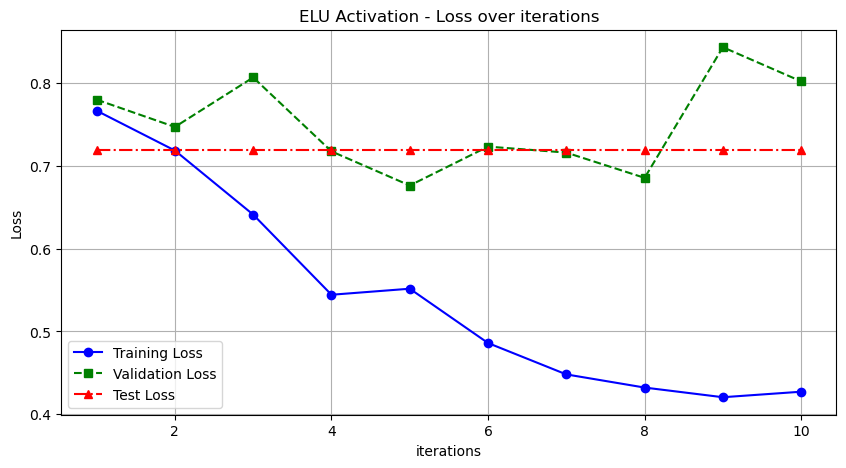

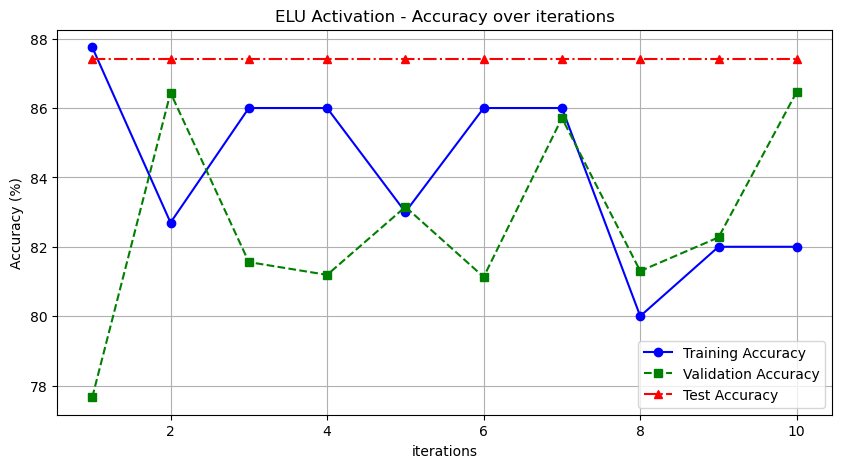


Training with GELU:
Iteration 1/10: Train Loss: 0.7336, Train Accuracy: 70.8989%, Val Loss: 0.7338, Val Accuracy: 64.6753%
Iteration 2/10: Train Loss: 0.7286, Train Accuracy: 83.0000%, Val Loss: 0.7381, Val Accuracy: 77.6623%
Iteration 3/10: Train Loss: 0.7214, Train Accuracy: 86.0000%, Val Loss: 0.7408, Val Accuracy: 76.3636%
Iteration 4/10: Train Loss: 0.7113, Train Accuracy: 89.0000%, Val Loss: 0.7478, Val Accuracy: 77.6623%
Iteration 5/10: Train Loss: 0.7035, Train Accuracy: 90.0000%, Val Loss: 0.7517, Val Accuracy: 71.1688%
Iteration 6/10: Train Loss: 0.6969, Train Accuracy: 84.0000%, Val Loss: 0.7622, Val Accuracy: 72.4675%
Iteration 7/10: Train Loss: 0.6948, Train Accuracy: 88.0000%, Val Loss: 0.7600, Val Accuracy: 75.0649%
Iteration 8/10: Train Loss: 0.6816, Train Accuracy: 90.0000%, Val Loss: 0.7672, Val Accuracy: 75.0649%
Iteration 9/10: Train Loss: 0.6728, Train Accuracy: 87.0000%, Val Loss: 0.7496, Val Accuracy: 73.7662%
Iteration 10/10: Train Loss: 0.6736, Train Accuracy:

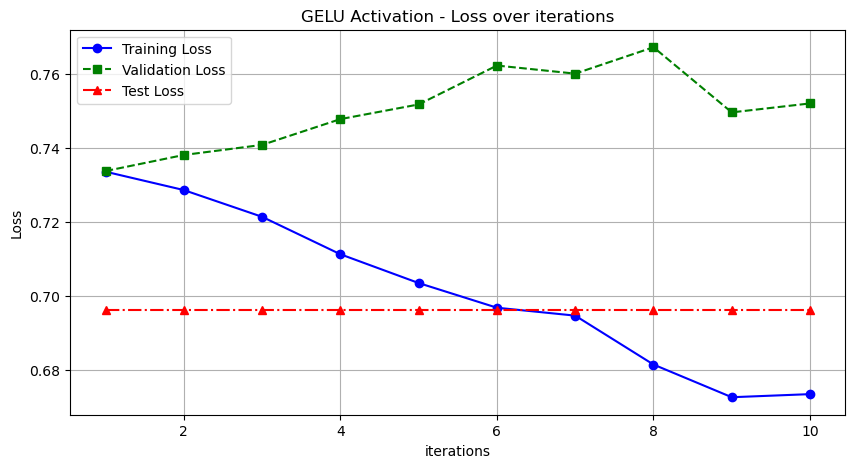

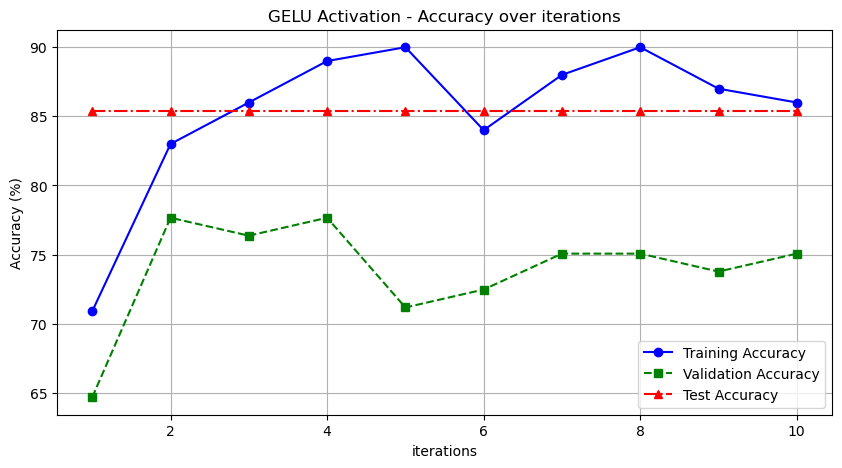

In [12]:
activationFns = [torch.nn.ReLU, torch.nn.LeakyReLU, torch.nn.ELU, torch.nn.GELU]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
iterations = 10

for activationFn in activationFns:
    criterion = torch.nn.CrossEntropyLoss()
    model = VggLikeActivationTest(activationFn=activationFn).to(device)
    lr = 0.01 if activationFn != torch.nn.GELU else 0.001  # Reduce LR for GELU

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    print(f"\nTraining with {activationFn.__name__}:")
    trainLosses, trainAccuracies, valLosses, valAccuracies, bestModel = trainModel(model, optimizer, criterion, trainLoader, valLoader, iterations, device)
    
    testLoss, testAccuracy = evaluateModel(model, testLoader, criterion, device)
    print(f"Test Accuracy with {activationFn.__name__}: {testAccuracy:.2f}%")
    
    plotResults(trainLosses, trainAccuracies, valLosses, valAccuracies, [testLoss] * iterations, [testAccuracy] * iterations, f'{activationFn.__name__} Activation')

### Experiment 3 1x1 Convolutions

In [13]:
class SimpleConvNetWithout1x1(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleConvNetWithout1x1, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc = torch.nn.Linear(128 * 224 * 224, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [14]:
class SimpleConvNetWith1x1(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleConvNetWith1x1, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1x1 = torch.nn.Conv2d(32, 64, kernel_size=1)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc = torch.nn.Linear(256 * 224 * 224, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv1x1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelWithout1x1 = SimpleConvNetWithout1x1().to(device)
modelWith1x1 = SimpleConvNetWith1x1().to(device)
optimizerWithout1x1 = torch.optim.SGD(modelWithout1x1.parameters(), lr=0.01, momentum=0.9)
optimizerWith1x1 = torch.optim.SGD(modelWith1x1.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

print("Model without 1x1 convolution:")
summary(modelWithout1x1, (3, 224, 224))

print("\nModel with 1x1 convolution:")
summary(modelWith1x1, (3, 224, 224))

Model without 1x1 convolution:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 64, 224, 224]          18,496
            Conv2d-3        [-1, 128, 224, 224]          73,856
            Linear-4                    [-1, 3]      19,267,587
Total params: 19,360,835
Trainable params: 19,360,835
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 85.75
Params size (MB): 73.86
Estimated Total Size (MB): 160.18
----------------------------------------------------------------

Model with 1x1 convolution:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 6

Iteration 1/10: Train Loss: 3131.4308, Train Accuracy: 74.2697%, Val Loss: 28019.5998, Val Accuracy: 81.5584%
Iteration 2/10: Train Loss: nan, Train Accuracy: 72.0225%, Val Loss: nan, Val Accuracy: 64.6753%
Iteration 3/10: Train Loss: nan, Train Accuracy: 77.6404%, Val Loss: nan, Val Accuracy: 64.6753%
Iteration 4/10: Train Loss: nan, Train Accuracy: 77.6404%, Val Loss: nan, Val Accuracy: 64.6753%
Iteration 5/10: Train Loss: nan, Train Accuracy: 77.6404%, Val Loss: nan, Val Accuracy: 64.6753%
Iteration 6/10: Train Loss: nan, Train Accuracy: 77.6404%, Val Loss: nan, Val Accuracy: 64.6753%
Iteration 7/10: Train Loss: nan, Train Accuracy: 77.6404%, Val Loss: nan, Val Accuracy: 64.6753%
Iteration 8/10: Train Loss: nan, Train Accuracy: 77.6404%, Val Loss: nan, Val Accuracy: 64.6753%
Iteration 9/10: Train Loss: nan, Train Accuracy: 77.6404%, Val Loss: nan, Val Accuracy: 64.6753%
Iteration 10/10: Train Loss: nan, Train Accuracy: 77.6404%, Val Loss: nan, Val Accuracy: 64.6753%
Iteration 1/10: 

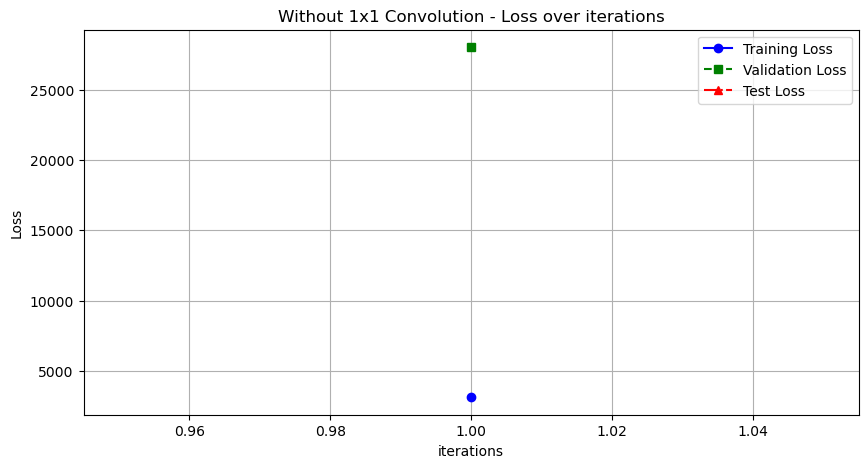

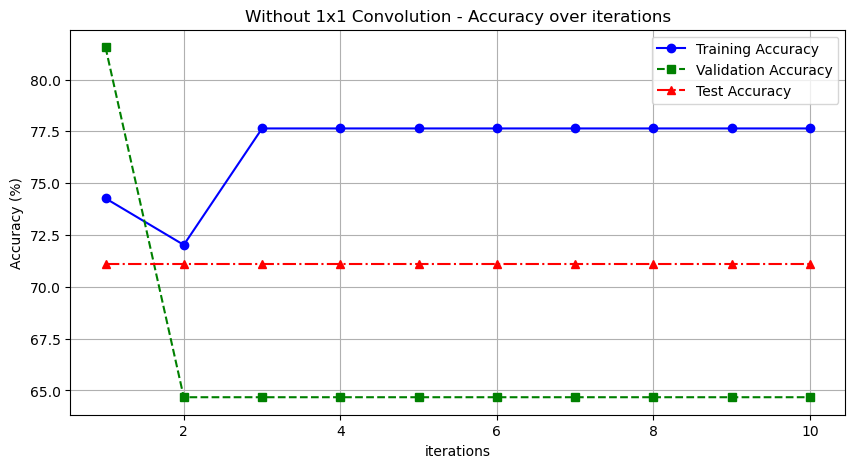

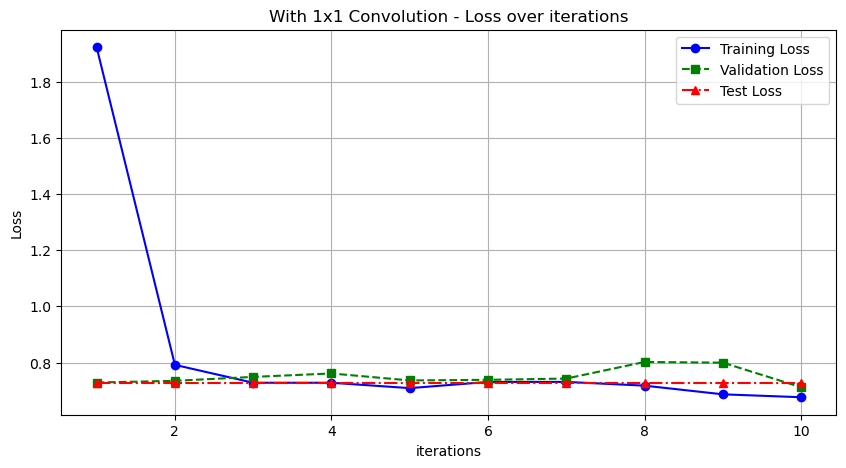

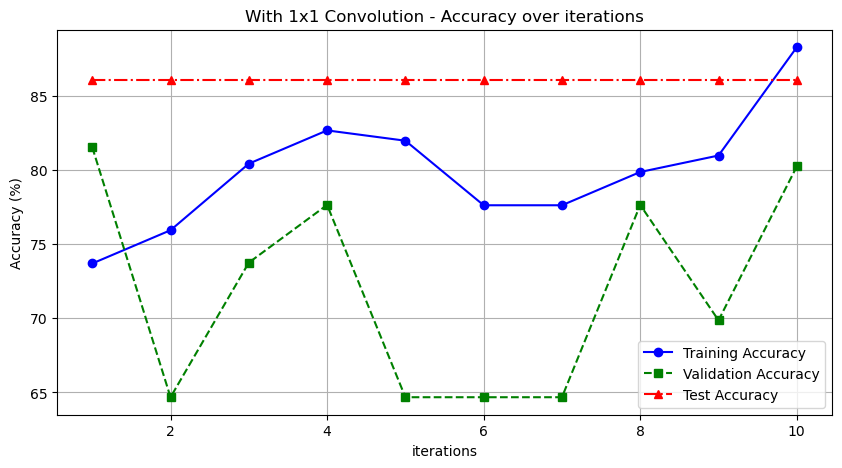

In [16]:

trainLossesWithout, trainAccuraciesWithout, valLossesWithout, valAccuraciesWithout, bestModelWithout = trainModel(
    modelWithout1x1, optimizerWithout1x1, criterion, trainLoader, valLoader)

trainLossesWith, trainAccuraciesWith, valLossesWith, valAccuraciesWith, bestModelWith = trainModel(
    modelWith1x1, optimizerWith1x1, criterion, trainLoader, valLoader)

testLossWithout, testAccuracyWithout = evaluateModel(modelWithout1x1, testLoader, criterion, device)
testLossWith, testAccuracyWith = evaluateModel(modelWith1x1, testLoader, criterion, device)

print(f"Test Accuracy (without 1x1): {testAccuracyWithout:.2f}%")
print(f"Test Accuracy (with 1x1): {testAccuracyWith:.2f}%")

plotResults(trainLossesWithout, trainAccuraciesWithout, valLossesWithout, valAccuraciesWithout, [testLossWithout] * iterations, [testAccuracyWithout] * iterations, "Without 1x1 Convolution")
plotResults(trainLossesWith, trainAccuraciesWith, valLossesWith, valAccuraciesWith, [testLossWith] * iterations, [testAccuracyWith] * iterations, "With 1x1 Convolution")

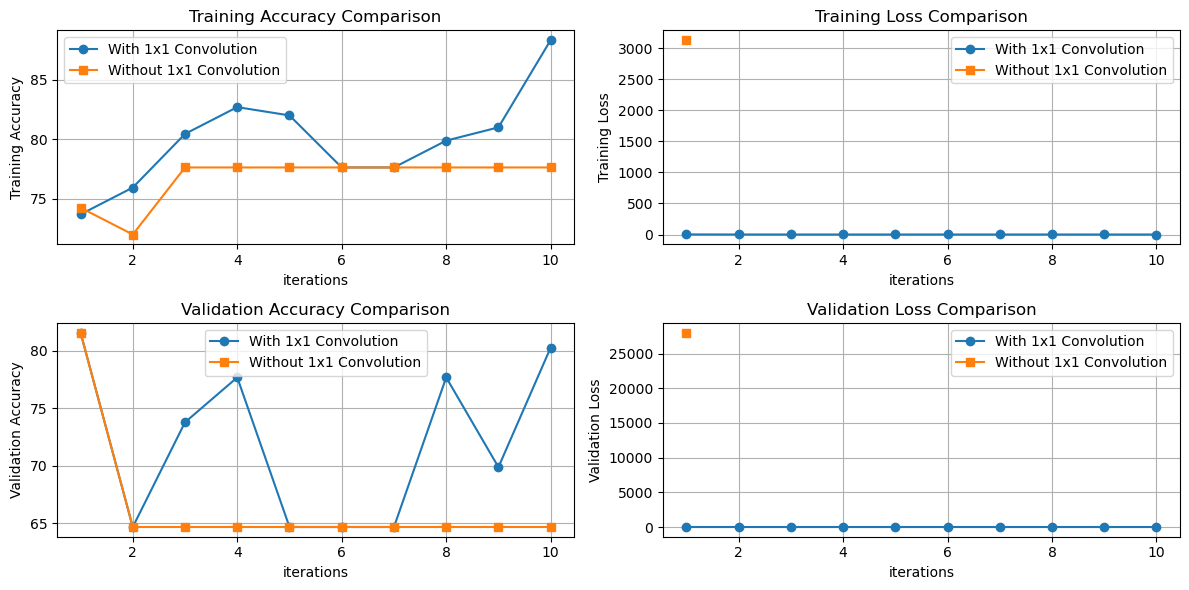

In [17]:
def plotComparisons(trainAcc1, trainLoss1, valAcc1, valLoss1, 
                              trainAcc2, trainLoss2, valAcc2, valLoss2, 
                              model1Name="With", model2Name="Without", iterations = 10):

    iterations = numpy.arange(1, iterations + 1)

    plot.figure(figsize=(12, 6))

    # Training Accuracy
    plot.subplot(2, 2, 1)
    plot.plot(iterations, trainAcc1, label=model1Name, marker='o')
    plot.plot(iterations, trainAcc2, label=model2Name, marker='s')
    plot.title('Training Accuracy Comparison')
    plot.xlabel('iterations')
    plot.ylabel('Training Accuracy')
    plot.legend()
    plot.grid()

    # Training Loss
    plot.subplot(2, 2, 2)
    plot.plot(iterations, trainLoss1, label=model1Name, marker='o')
    plot.plot(iterations, trainLoss2, label=model2Name, marker='s')
    plot.title('Training Loss Comparison')
    plot.xlabel('iterations')
    plot.ylabel('Training Loss')
    plot.legend()
    plot.grid()

    # Validation Accuracy
    plot.subplot(2, 2, 3)
    plot.plot(iterations, valAcc1, label=model1Name, marker='o')
    plot.plot(iterations, valAcc2, label=model2Name, marker='s')
    plot.title('Validation Accuracy Comparison')
    plot.xlabel('iterations')
    plot.ylabel('Validation Accuracy')
    plot.legend()
    plot.grid()

    # Validation Loss
    plot.subplot(2, 2, 4)
    plot.plot(iterations, valLoss1, label=model1Name, marker='o')
    plot.plot(iterations, valLoss2, label=model2Name, marker='s')
    plot.title('Validation Loss Comparison')
    plot.xlabel('iterations')
    plot.ylabel('Validation Loss')   
    plot.legend()
    plot.grid()

    plot.tight_layout()
    plot.show()


plotComparisons(
    trainAccuraciesWith, trainLossesWith, valAccuraciesWith, valLossesWith,
    trainAccuraciesWithout, trainLossesWithout, valAccuraciesWithout, valLossesWithout,
    model1Name="With 1x1 Convolution", model2Name="Without 1x1 Convolution", iterations=iterations
)


# Yes, there is vanishing gradient's problem<br>
# The gradient norm of layer 3 (10<sup>-8</sup>) is 100 times smaller than the gradient norm of layer 15(10<sup>-6</sup>) <br>
# The gradient norm of layer 27 (10<sup>-4</sup>) is 100 times smaller than the gradient norm of layer 38(10<sup>-2</sup>)